In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf


np.set_printoptions(precision=3,suppress=True)

### 데이터셋의 경우 UCI Machine Learning Repository 에서 제공하는 auto-mpg 데이터를 활용하였다

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
# 데이터가 null값으로 ?를 사용하고 있어 na_values옵션을 추가해주도록 하겠다
dataset = pd.read_csv(url, names = column_names,
                          na_values='?', comment= '\t',
                          sep = ' ', skipinitialspace=True)

In [4]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# 데이터 null값들의 합을 본다.
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# null값을 처리하는 방법에는 여러가지가 있으나 여기서는 간단히 지워주도록 하겠다
dataset = dataset.dropna()

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
# origin 컬럼은 국가를 나타내는 범주형 데이터이므로 원핫인코딩 처리를 해주도록 하겠다
dataset = pd.get_dummies(dataset, columns=['Origin'])
dataset.rename(columns={'Origin_1' : 'USA','Origin_2' : 'EU','Origin_3' : 'JP' }, inplace=True)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,EU,JP
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [9]:
# 80% 를 random하게 추출하여 train_data로 사용하고 남은 데이터를 test_data로 사용
train_data = dataset.sample(frac=0.8, random_state=42)
test_data = dataset.drop(train_data.index)

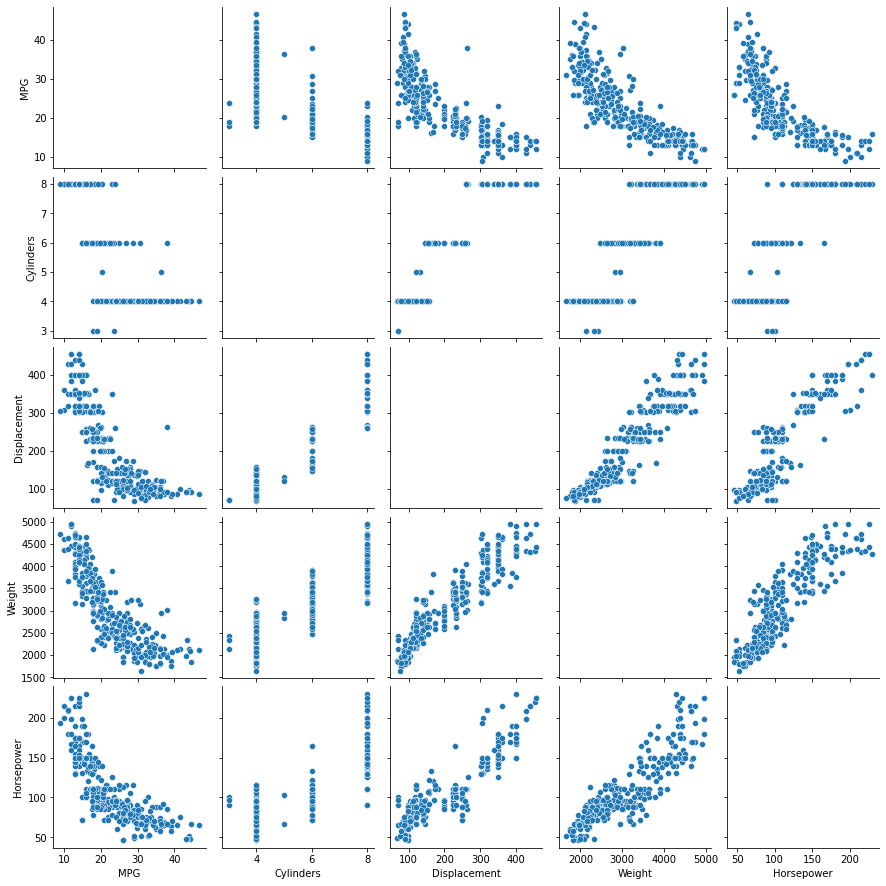

In [18]:
sns.pairplot(train_data[['MPG', 'Cylinders', 'Displacement', 'Weight','Horsepower']], diag_kind='scatter')

### 위의 그래프를 통해 MPG가 Weight와 Displacment, Horsepower 에 관련이 있음을 알 수 있다

In [12]:
# 데이터들의 분포와 표준편차들을 표로 보여준다.
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.000,1.0
EU,314.0,0.171975,0.377961,0.0,0.000,0.0,0.000,1.0
JP,314.0,0.203822,0.403481,0.0,0.000,0.0,0.000,1.0


In [13]:
# 데이터의 feature와 target을 나누어 준다.
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [14]:
# 밑에서 정규화를 진행해주기 전에 각각 컬럼별 평균과 표준편차를 확인해본다.
train_data.describe().transpose()[['mean','std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
USA,0.624204,0.485101
EU,0.171975,0.377961
JP,0.203822,0.403481


In [15]:
# 정규화는 케라스의 Normalization을 이용하여 진행하겠다.
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(train_features))

In [16]:
# 표준화를 위한 함수에 평균값을 확인하며 위에서 출력했던 값과 비교해 본다.
print(normalizer.mean.numpy())

[[   5.532  197.855  105.971 3005.746   15.511   75.911    0.624    0.172
     0.204]]


In [17]:
# 예시로 표준화가 진행된 모습을 1행 출력해보겠다.
first = np.array(train_features[:1])
print('first ex : ',first)
print('Normalized : ',normalizer(first).numpy())

first ex :  [[   4.   96.   69. 2189.   18.   72.    0.    1.    0.]]
Normalized :  [[-0.887 -0.958 -0.934 -0.952  0.889 -1.062 -1.289  2.194 -0.506]]


## Linear regression with one input

In [19]:
# 하나의 컬럼을 이용하여 모델을 회귀모델을 작성할 경우에 대해서 알아보겠다.
horsepower = np.array(train_features['Horsepower'])
# input 값이 하나인 단일컬럼에 대해 정규화를 진행하므로 axis축은 None로 바꾸어준다.
horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,],axis=None)
horsepower_normalizer.adapt(horsepower)

In [20]:
# 정규화한 horsepower에 하나의 dense레이어를 통과시켜준다.
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [21]:
# 옵티마이저는 adam과 lossfunction으로는 절대오차를 사용했다.
horsepower_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [22]:
# 훈련은 100회 진행하고 출력은 생략, val_data는 20%로 설정하고 학습을 진행
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 3.53 s, sys: 907 ms, total: 4.43 s
Wall time: 3.22 s


In [23]:
# 학습이 진행되는 동안 손실을 확인해본다.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.905730,3.316809,95
96,3.904958,3.322152,96
97,3.907914,3.312799,97
98,3.905258,3.329990,98
99,3.905400,3.335669,99


In [24]:
# 그래프는 밑에서 여러번 출력할 예정이므로 함수로 만들어 재사용을 진행해주겠다.
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()

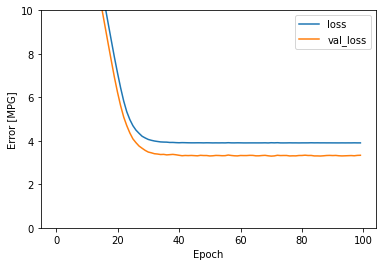

In [25]:
plot_loss(history)

In [26]:
test_rs = {}
test_rs['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [27]:
x = tf.linspace(0,250,251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [28]:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

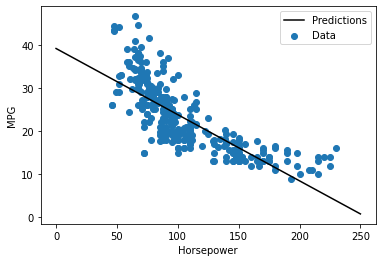

In [29]:
plot_horsepower(x,y)

## Linear regression with multiple inputs

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

In [31]:
linear_model.predict(train_features[:5])

1/1 [==============================] - 0s 50ms/step


array([[-1.289],
       [-0.619],
       [-3.307],
       [-0.01 ],
       [-0.162]], dtype=float32)

In [32]:
linear_model.layers[1].kernel, linear_model.layers[1].bias

(<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
 array([[ 0.374],
        [ 0.218],
        [ 0.597],
        [ 0.55 ],
        [ 0.725],
        [ 0.08 ],
        [ 0.412],
        [ 0.02 ],
        [-0.519]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [33]:
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 3.54 s, sys: 868 ms, total: 4.41 s
Wall time: 3.03 s


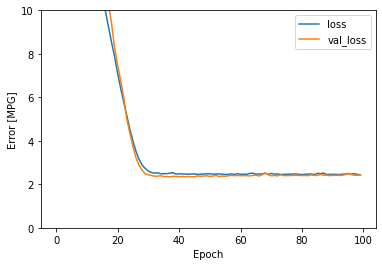

In [35]:
plot_loss(history)

In [36]:
test_rs['linear_model'] = linear_model.evaluate(
    test_features, test_labels,verbose =0
)

## DNN을 이용한 회귀

In [37]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss= 'mean_absolute_error',
              optimizer = tf.keras.optimizers.Adam(0.001))
    return model

### DNN과 단일컬럼을 이용한 회귀

In [38]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [39]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [40]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split = 0.2,
    verbose = 0, epochs = 100
)

CPU times: user 4.87 s, sys: 1.61 s, total: 6.48 s
Wall time: 3.43 s


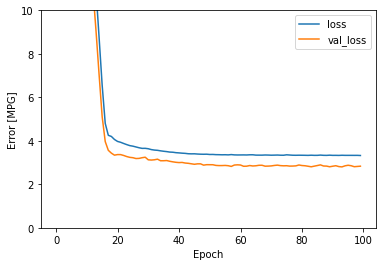

In [41]:
plot_loss(history)

In [42]:
x = tf.linspace(0,250,251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


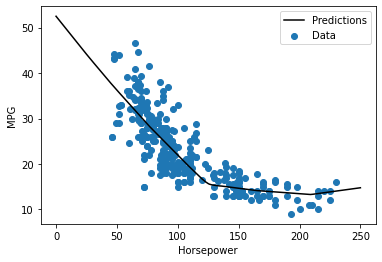

In [43]:
plot_horsepower(x,y)

In [44]:
test_rs['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'],
                                                                     test_labels,verbose=0)

## DNN을 이용한 다중 입력 회귀

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split = 0.2,
    verbose = 0, epochs = 100
)

CPU times: user 4.81 s, sys: 1.72 s, total: 6.53 s
Wall time: 3.38 s


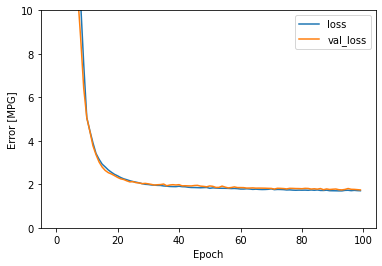

In [47]:
plot_loss(history)

In [48]:
test_rs['dnn_model']=dnn_model.evaluate(test_features, test_labels,verbose=0)

In [49]:
pd.DataFrame(test_rs,index=['Mean absolute error [MPG]'])

,horsepower_model,linear_model,dnn_horsepower_model,dnn_model
Mean absolute error [MPG],3.957477,2.498192,3.463197,1.744583


3/3 [==============================] - 0s 2ms/step


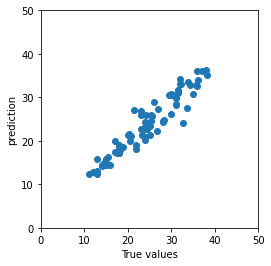

In [50]:
test_pred = dnn_model.predict(test_features).flatten()

a=plt.axes(aspect='equal')
plt.scatter(test_labels, test_pred)
plt.xlabel('True values')
plt.ylabel('prediction')
lims = [0,50]
plt.xlim(lims)
plt.ylim(lims)
plt.show()

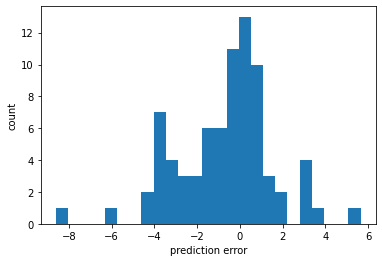

In [51]:
error = test_pred - test_labels
plt.hist(error, bins=25)
plt.xlabel('prediction error')
plt.ylabel('count')
plt.show()